In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
import ipywidgets as widgets
sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib notebook

In [2]:
data = pd.read_csv('./hw_2_data/flowers.csv')

In [3]:
class Brusher(object):
    """
    Creates the brushing object
    data: Pandas dataframe
    feature_list: list of column name string for the data that you wish to plot
    color_by: column name string of the column used to color the data points
    """
    def __init__(self, data, feature_list, color_by):
        self.data = data
        self.selected_data = None
        self.feature_list = feature_list
        self.color_by = color_by
        self.n_features = len(self.feature_list)
        
        # Plotting attributes and methods
        self.fig = plt.figure(figsize=(3*self.n_features, 3*self.n_features))
        self.setup_axes()
        self.define_colors()
        self.plot()
        
        # Interactivity attributes and methods
        self.x0 = None
        self.x1 = None
        self.y0 = None
        self.y1 = None
        self.select_axis = None
        self.rect = None
        self.cids = []
        self.is_pressed = False
        self.connect()
        
    def setup_axes(self):
        """Creates a grid of axes for all of the features"""
        for i in range(self.n_features):
            for j in range(i+1):
                ax = plt.subplot(self.n_features, self.n_features, self.n_features*i+j+1)
    
    def define_colors(self, palette='husl'):
        """Maps categories to colors and draws a legend"""
        categories = self.color_by.unique()
        palette = sns.color_palette(palette=palette, n_colors=len(categories))
        colormap = {cat: palette[i] for i, cat in enumerate(categories)}
        self.data['color'] = pd.Series([colormap[color] for color in self.color_by])
        handles = [patches.Patch(color=colormap[cat]) for cat in categories]
        labels = categories
        self.fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.9, 0.9), title=self.color_by.name)
    
    def plot(self, delete=False):
        """Plots all of the data points on the predefined axes"""
        self.axes_data = {}
        ax_index = 0
        # When we want to delete data, we can set delete=True
        # This redefines the data to be everything that is not selected
        if delete:
            self.data = self.data[~self.data.isin(self.selected_data)].dropna()
        for i in range(self.n_features):
            for j in range(i+1):
                ax = self.fig.axes[ax_index]
                x_data = self.data[feature_list[j]]
                y_data = self.data[feature_list[i]]
                if self.selected_data is not None:
                    sel_x_data = self.selected_data[feature_list[j]]
                    sel_y_data = self.selected_data[feature_list[i]]
                ax.set_xlim(min(x_data), max(x_data))
                ax.set_ylim(min(y_data), max(y_data))
                # Get rid of redundant axis labels
                if j != 0:
                    plt.setp(ax.get_yticklabels(), visible=False)
                else:
                    ax.set_ylabel(y_data.name)
                if i != self.n_features-1:
                    plt.setp(ax.get_xticklabels(), visible=False)
                else:
                    ax.set_xlabel(x_data.name)
                    
                # If we have some data selected, and we're not deleting data, plot the selected data
                # points and the rest have lowered opacity
                if (self.selected_data is not None and len(self.selected_data) != 0) and not delete:
                    ax.scatter(sel_x_data, sel_y_data, color=self.selected_data['color'], linewidth=0)
                    ax.scatter(x_data, y_data, color=self.data['color'], linewidth=0, alpha=0.1)
                # Otherwise, plot all the data points
                else:
                    ax.scatter(x_data, y_data, color=self.data['color'], linewidth=0)
                # Store which data was plotted in which axis for later
                self.axes_data[ax] = (x_data, y_data)
                ax_index += 1 # Looping through each axis

    def connect(self):
        """Connects all of the mpl event handlers"""
        self.cids.append(self.fig.canvas.mpl_connect('button_press_event', self.on_click))
        self.cids.append(self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion))
        self.cids.append(self.fig.canvas.mpl_connect('button_release_event', self.on_release))
        self.cids.append(self.fig.canvas.mpl_connect('key_press_event', self.on_keypress))
        
    def disconnect(self):
        """Disconnects all mpl event handlers"""
        [self.fig.canvas.mpl_disconnect(cid) for cid in cids]
        
    def on_click(self, event):
        """Runs when a mouse button is pressed"""
        if self.rect is not None:
            self.rect.remove()
        self.x0 = event.xdata
        self.y0 = event.ydata
        # Start drawing a rectangle
        self.rect = patches.Rectangle((self.x0, self.y0), 0, 0, fc='k', alpha=0.1, linewidth=2)
        self.select_axis = event.inaxes
        self.select_axis.add_patch(self.rect)
        self.is_pressed = True
                
    def on_motion(self, event):
        """Runs when the mouse is moved and a mouse button is pressed"""
        # If the mouse moves outside the axis the click & drag started in, do nothing
        if self.is_pressed and event.inaxes == self.select_axis:
            self.x1 = event.xdata
            self.y1 = event.ydata
            # Update rectangle parameters
            self.rect.set_width(self.x1 - self.x0)
            self.rect.set_height(self.y1 - self.y0)
            # Only redraw the rectangle to speed up the animation
            self.select_axis.draw_artist(self.rect)
            self.fig.canvas.blit(self.select_axis.bbox)

    def on_release(self, event):
        """Runs when the mouse button is released"""
        if self.is_pressed and event.inaxes == self.select_axis:
            # Do the same thing as when moving the mouse and holding the button
            self.x1 = event.xdata
            self.y1 = event.ydata
            self.rect.set_width(self.x1 - self.x0)
            self.rect.set_height(self.y1 - self.y0)
            self.select_axis.draw_artist(self.rect)
            self.fig.canvas.blit(self.select_axis.bbox)
        self.is_pressed = False
        # Get the data inside the rectangle
        self.select_data()
        # Remove the rectangle and redraw the plots
        self.rect = None
        for ax in self.fig.axes:
            ax.clear()
        self.plot()
        
    def on_keypress(self, event):
        """Runs when the 'd' button is pressed"""
        if event.key == 'd':
            for ax in self.fig.axes:
                ax.clear()
            self.plot(delete=True)
                  
    def select_data(self):
        """Chooses all of the data points within the bounds of the selection rectangle"""
        self.x_series, self.y_series = self.axes_data[self.select_axis]
        x_cut = ((self.x_series > min([self.x0, self.x1])) & (self.x_series < max([self.x0, self.x1])))
        y_cut = ((self.y_series > min([self.y0, self.y1])) & (self.y_series < max([self.y0, self.y1])))
        self.selected_data = self.data[x_cut & y_cut]
        # If nothing passes these cuts, assume that the user wants to reset
        if len(self.selected_data) == 0:
            self.selected_data = self.data

<IPython.core.display.Javascript object>


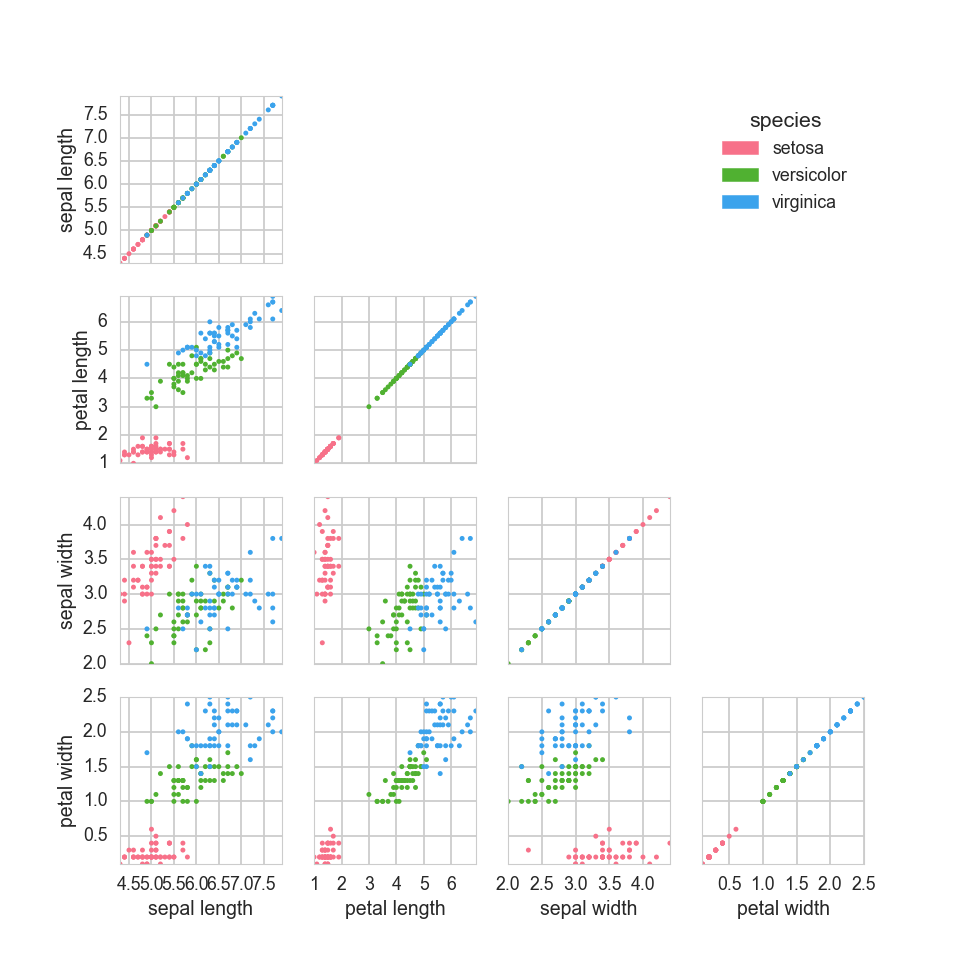

In [4]:
feature_list = ['sepal length','petal length', 'sepal width', 'petal width']
b = Brusher(data, feature_list, color_by=data['species'])